In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore', '.*sample_weight.*', )

In [197]:
from splinator.estimators import LinearSplineLogisticRegression

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression

In [192]:
X, y = make_classification(n_samples=50000, n_features=10, n_informative=2, n_redundant=8, flip_y=0.15)

# split train, test for calibration
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [194]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

clf_pred_dev = clf.predict_proba(X_dev)[:,1]
clf_pred_test = clf.predict_proba(X_test)[:,1]

In [169]:
roc_auc_score(y_score=clf_pred_dev, y_true=y_dev)

0.9023362922140319

In [178]:
lr = LogisticRegression()                                                       
lr.fit( clf_pred_dev.reshape( -1, 1 ), y_dev )
lr_calibrated = lr.predict_proba( clf_pred_test.reshape( -1, 1 ))[:,1]

In [179]:
ir = IsotonicRegression(increasing=True, y_max=1, y_min=0, out_of_bounds='clip')                                                       
ir.fit( clf_pred_dev.reshape( -1, 1 ), y_dev )
ir_calibrated = ir.predict( clf_pred_test.reshape( -1, 1 ) )

In [182]:
lslr = LinearSplineLogisticRegression(
        n_knots=100, 
        monotonicity="increasing", 
        minimizer_options={'disp': True}, 
        method='SLSQP', 
        two_stage_fitting_initial_size=2000
    )
lslr.fit( clf_pred_dev.reshape( -1, 1 ), y_dev )
lslr_calibrated = lslr.predict( clf_pred_test.reshape( -1, 1 ))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 721.4435775295738
            Iterations: 49
            Function evaluations: 63
            Gradient evaluations: 49
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1695.810876917216
            Iterations: 48
            Function evaluations: 56
            Gradient evaluations: 48


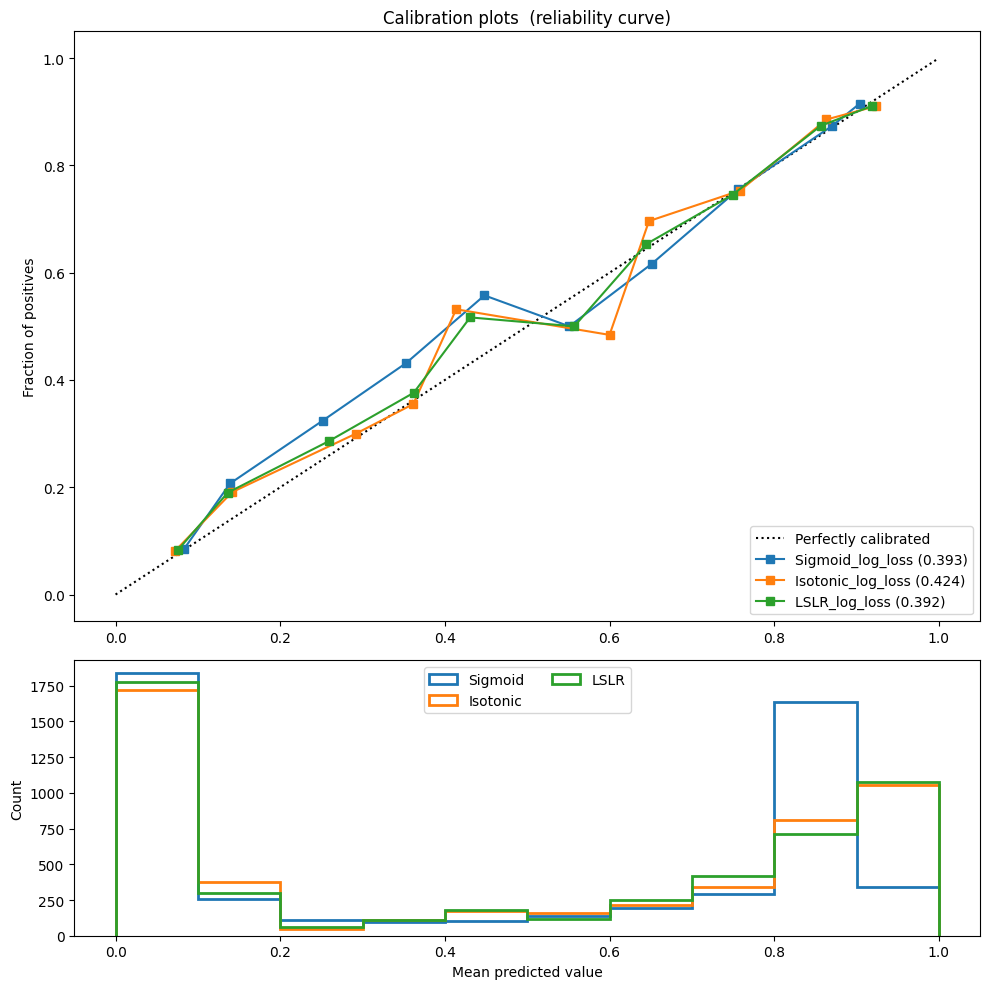

In [190]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


def plot_calibration_curve():
    """Plot calibration curve for est w/o and with calibration. """
    
    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for prob_pos, name in [(lr_calibrated, 'Sigmoid'),
                      (ir_calibrated, 'Isotonic'),
                      (lslr_calibrated, 'LSLR')]:

        clf_score = log_loss(y_test, prob_pos)
 

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name + "_log_loss", clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve()

plt.show()

In [196]:
LinearSplineLogisticRegression(**lslr.get_params())

LinearSplineLogisticRegression(minimizer_options={'disp': True},
                               monotonicity='increasing', n_knots=100,
                               two_stage_fitting_initial_size=2000)